# <center>**Predicting Survivors Aboard the Titanic**</center>

<center><img src='http://cdn.britannica.com/72/153172-050-EB2F2D95/Titanic.jpg'></center>  



In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# Imports

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve

import re

%matplotlib inline 
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.shape, test.shape

((891, 12), (418, 11))

# 1 -  EDA



In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


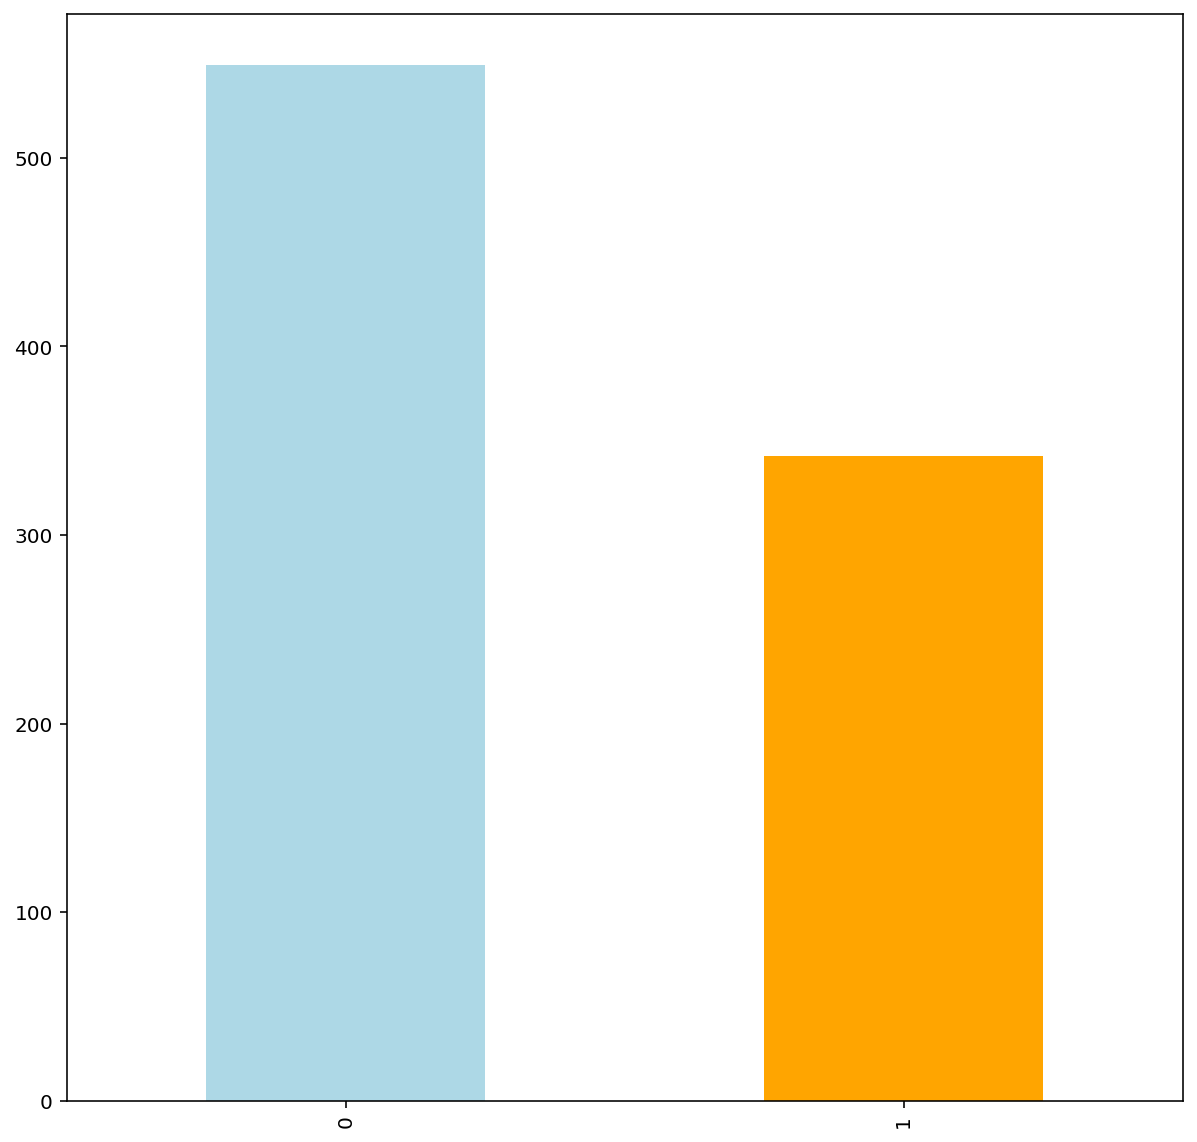

In [8]:
train["Survived"].value_counts().plot(kind='bar', color=["lightblue", "orange"], figsize=(10,10));

We see that roughly 60% of the passengers lost their lives.

In [9]:
train['Survived'].value_counts()/len(train) *100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

Let us look at each feature using histograms

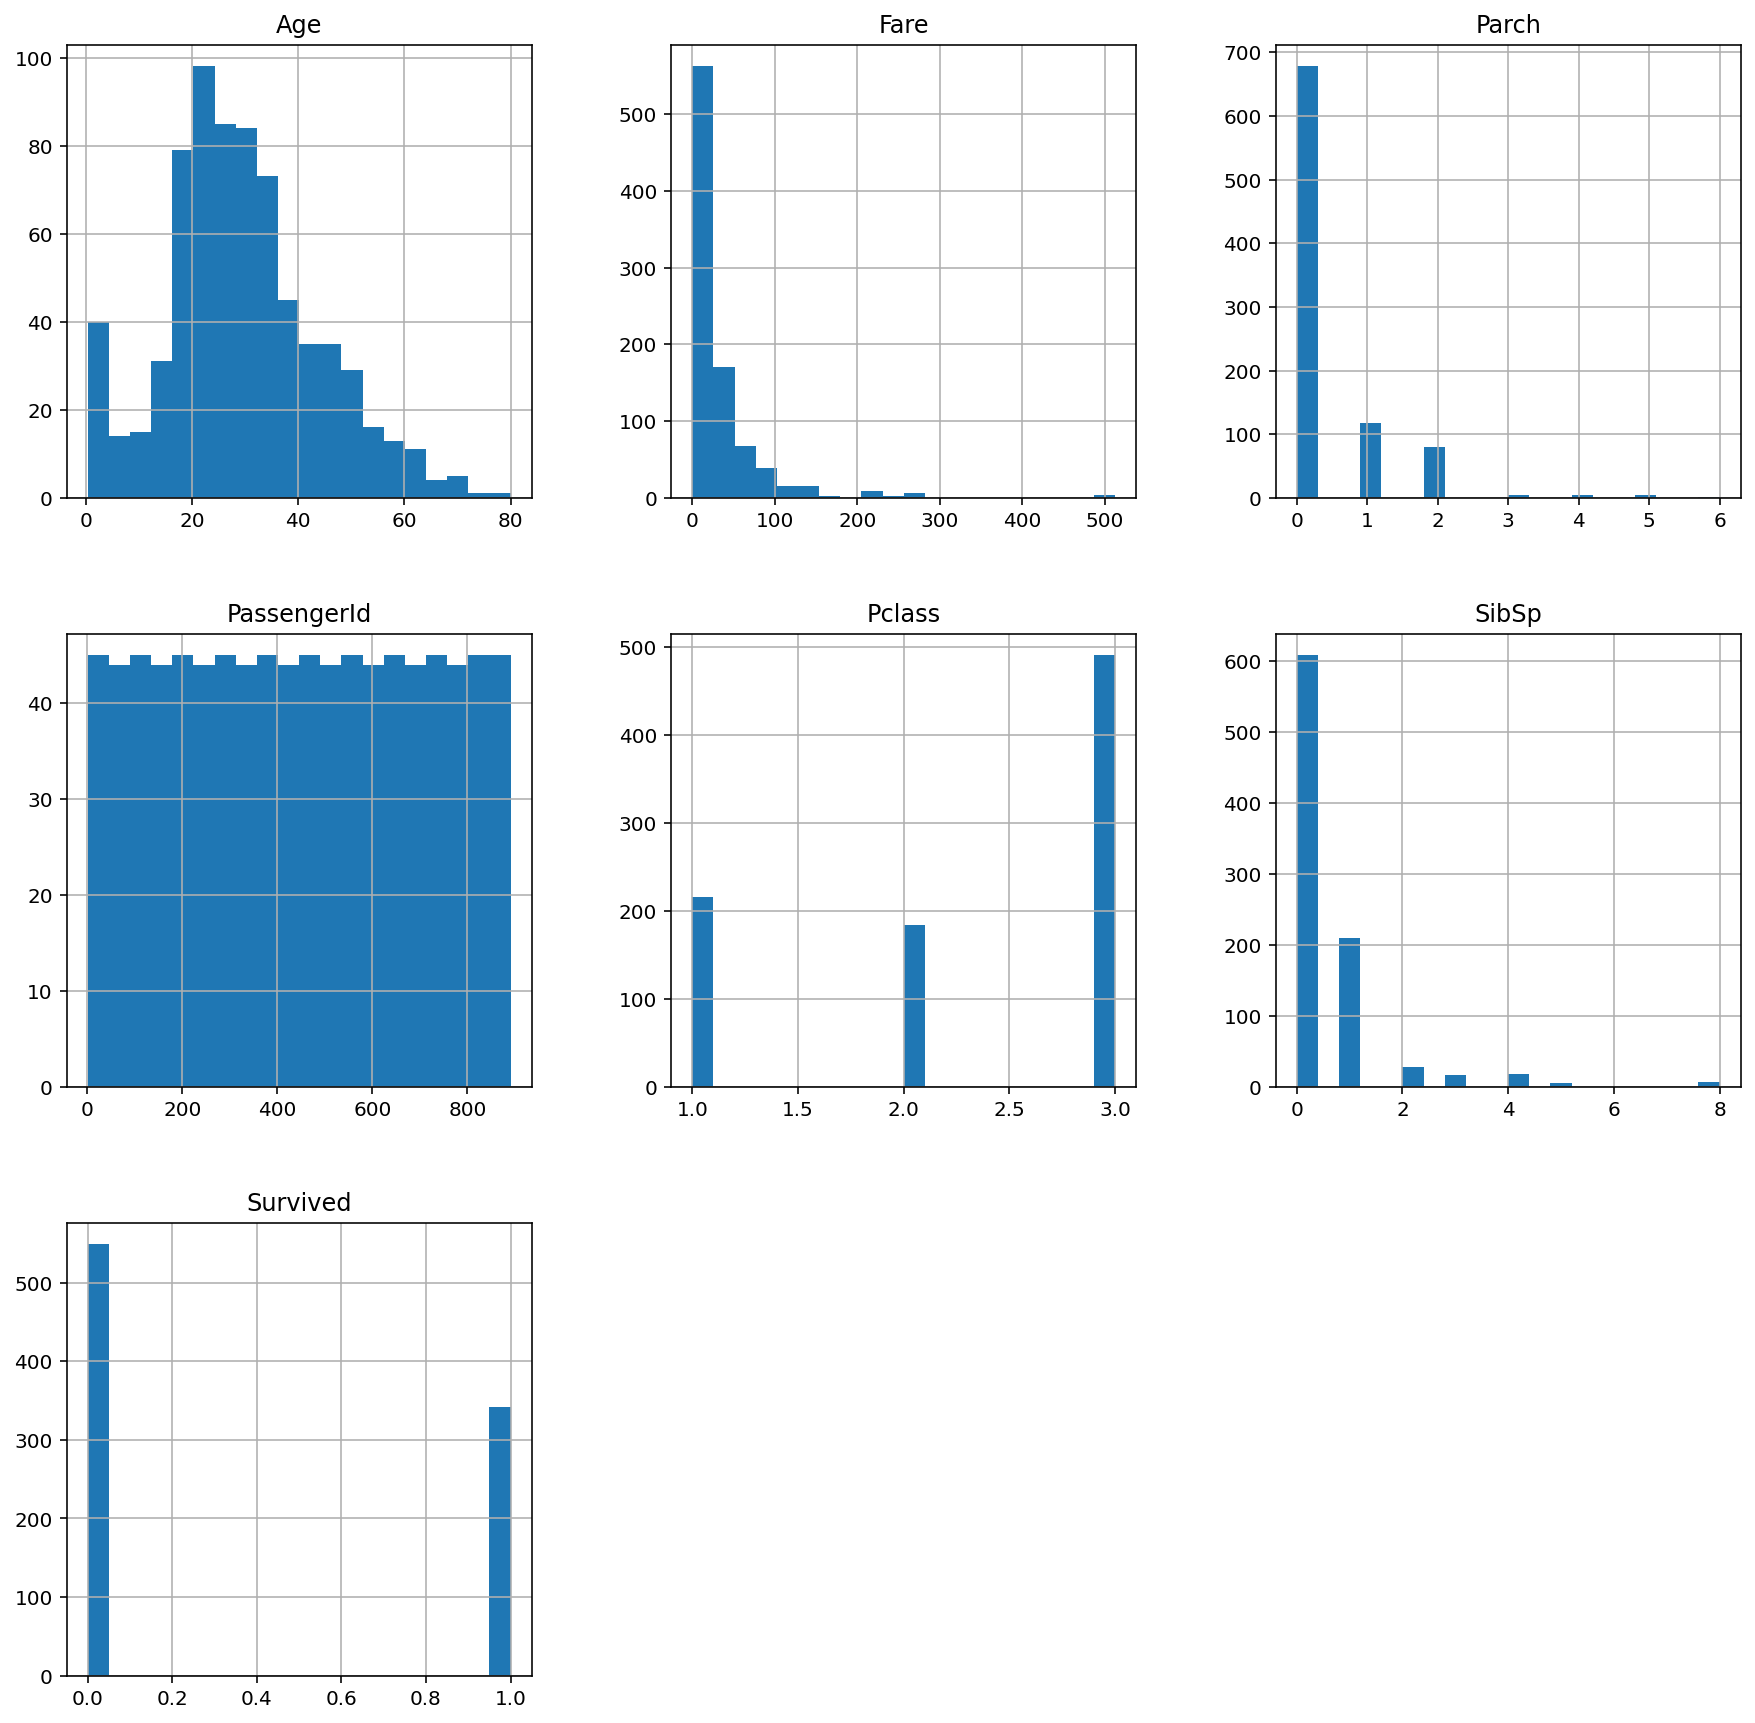

In [10]:
train.hist(figsize=(15,15), bins=20)
plt.show()

## 1.1 - Survival by Sex

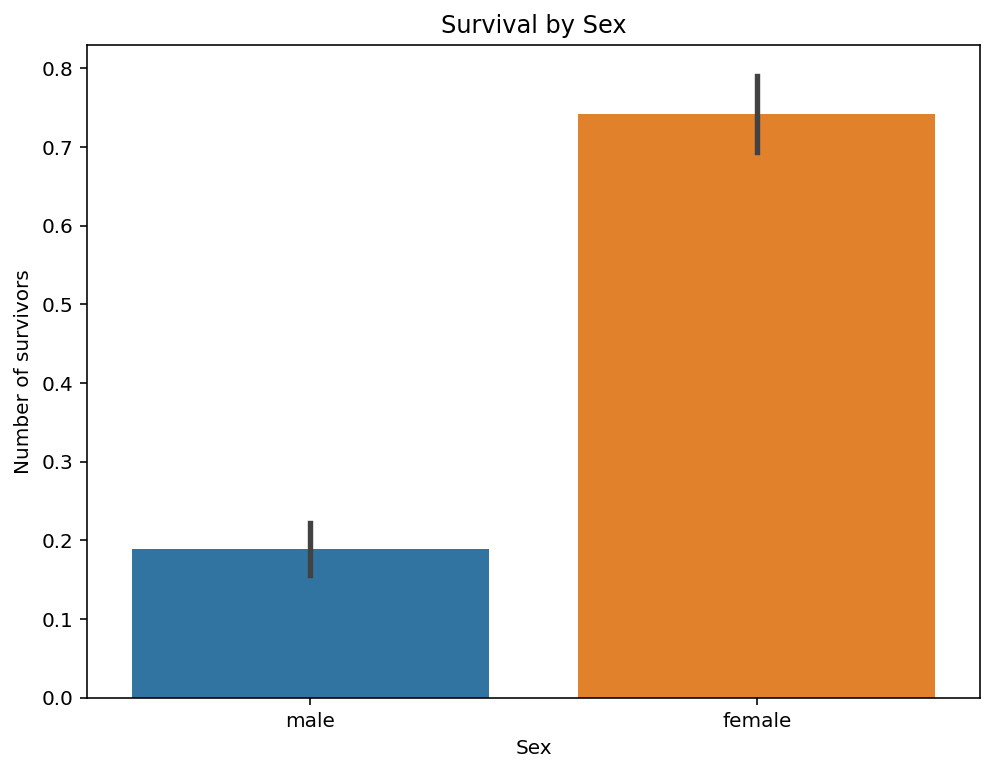

In [11]:
plt.figure(figsize=(8,6))
sns.barplot(x='Sex', y='Survived', data=train)

plt.title("Survival by Sex")
plt.xlabel("Sex")
plt.ylabel("Number of survivors");





For more female passengers survived the accident compared to male

## 1.2 - Survival by Passenger Class 

First class survival percentage - 62.96%
Second class survival percentage - 47.28%
Third class survival percentage - 24.24%


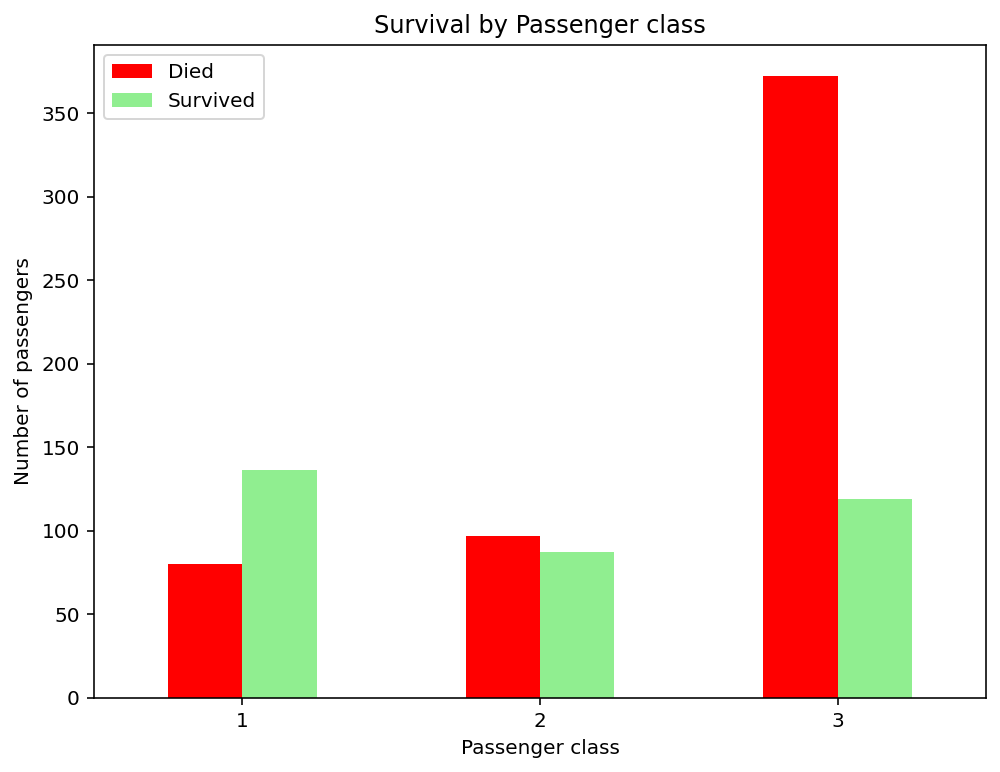

In [12]:
pd.crosstab(train["Pclass"], train["Survived"]).plot(kind="bar",
                                                     figsize=(8,6),
                                                     color=["red", "lightgreen"])

plt.title("Survival by Passenger class")
plt.xlabel("Passenger class")
plt.ylabel("Number of passengers")
plt.legend(["Died", "Survived"])
plt.xticks(rotation=0)

print(f"First class survival percentage - {train['Survived'][train['Pclass'] == 1].value_counts(normalize = True)[1]*100:0.2f}%")
print(f"Second class survival percentage - {train['Survived'][train['Pclass'] == 2].value_counts(normalize = True)[1]*100:0.2f}%")
print(f"Third class survival percentage - {train['Survived'][train['Pclass'] == 3].value_counts(normalize = True)[1]*100:0.2f}%")

From this chart, it appears **likelihood of death increases with class**. It is worth noting that a lower class number actually represents higher class status.

The number of survivors seems to go up in the 3rd class, but looking at the survival percentage makes it clear that indeed **the rate was lower with increasing class**

We can further break down this class data by more variables to see how they differed in the three classes.

### 1.2.1 - Sex

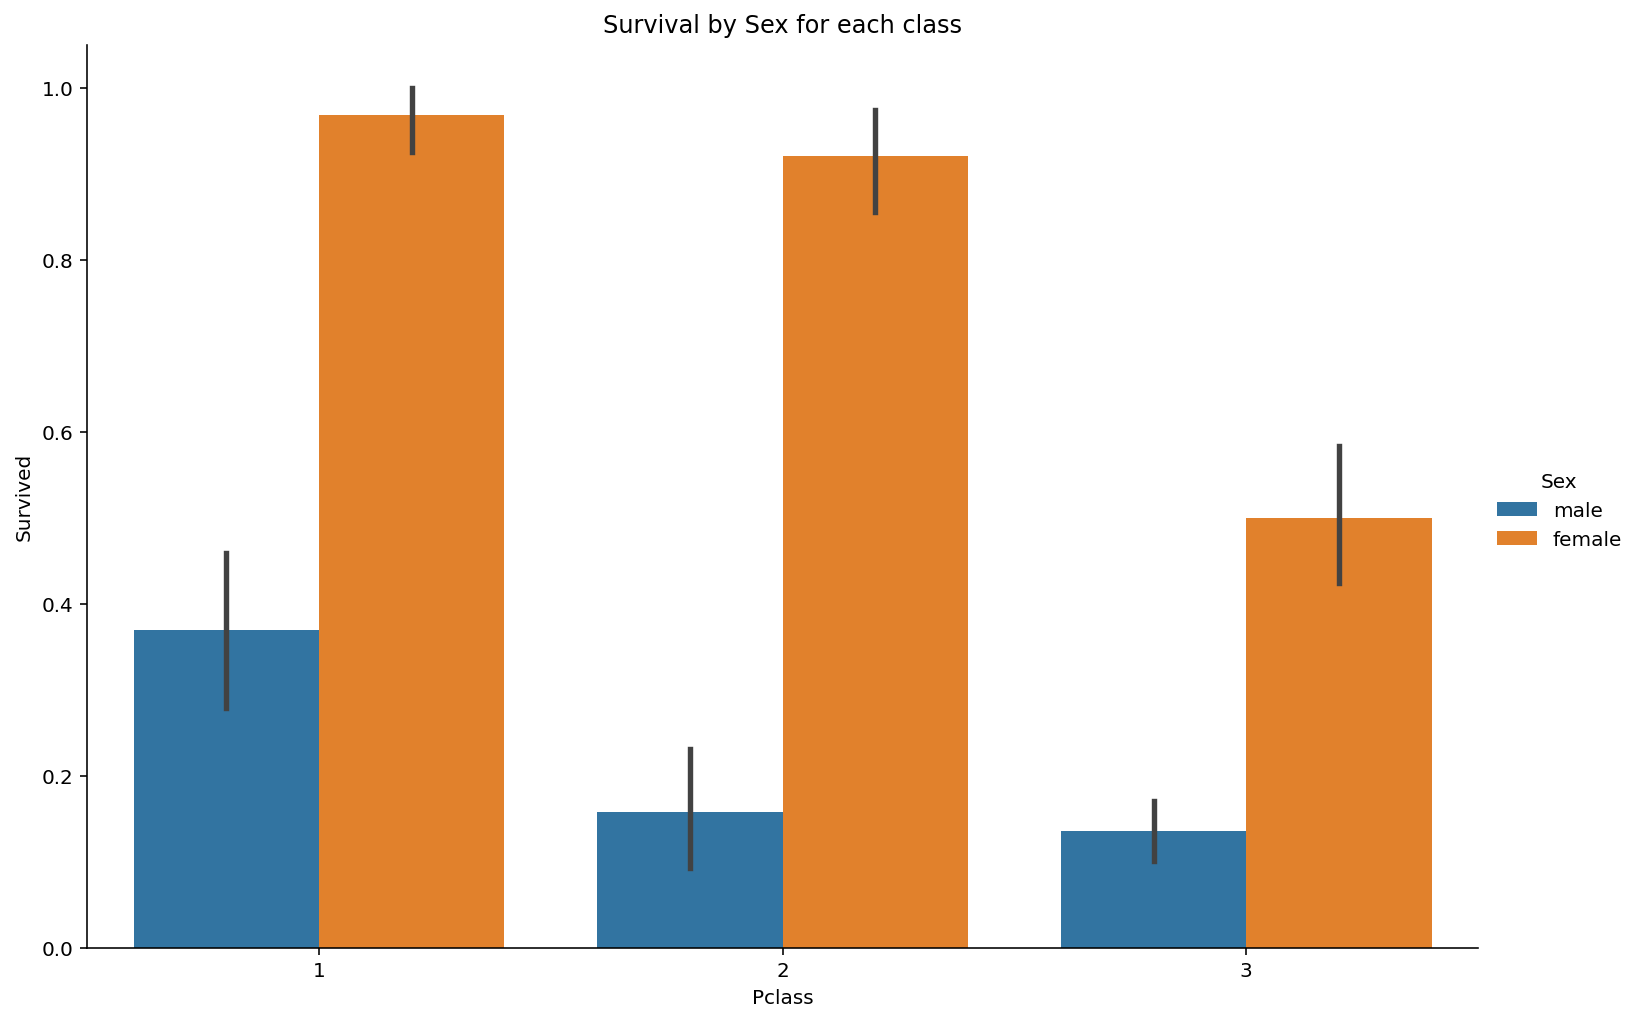

In [13]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="bar", data=train, height=7, aspect=1.5)
plt.title("Survival by Sex for each class");

### 1.2.2 - Age

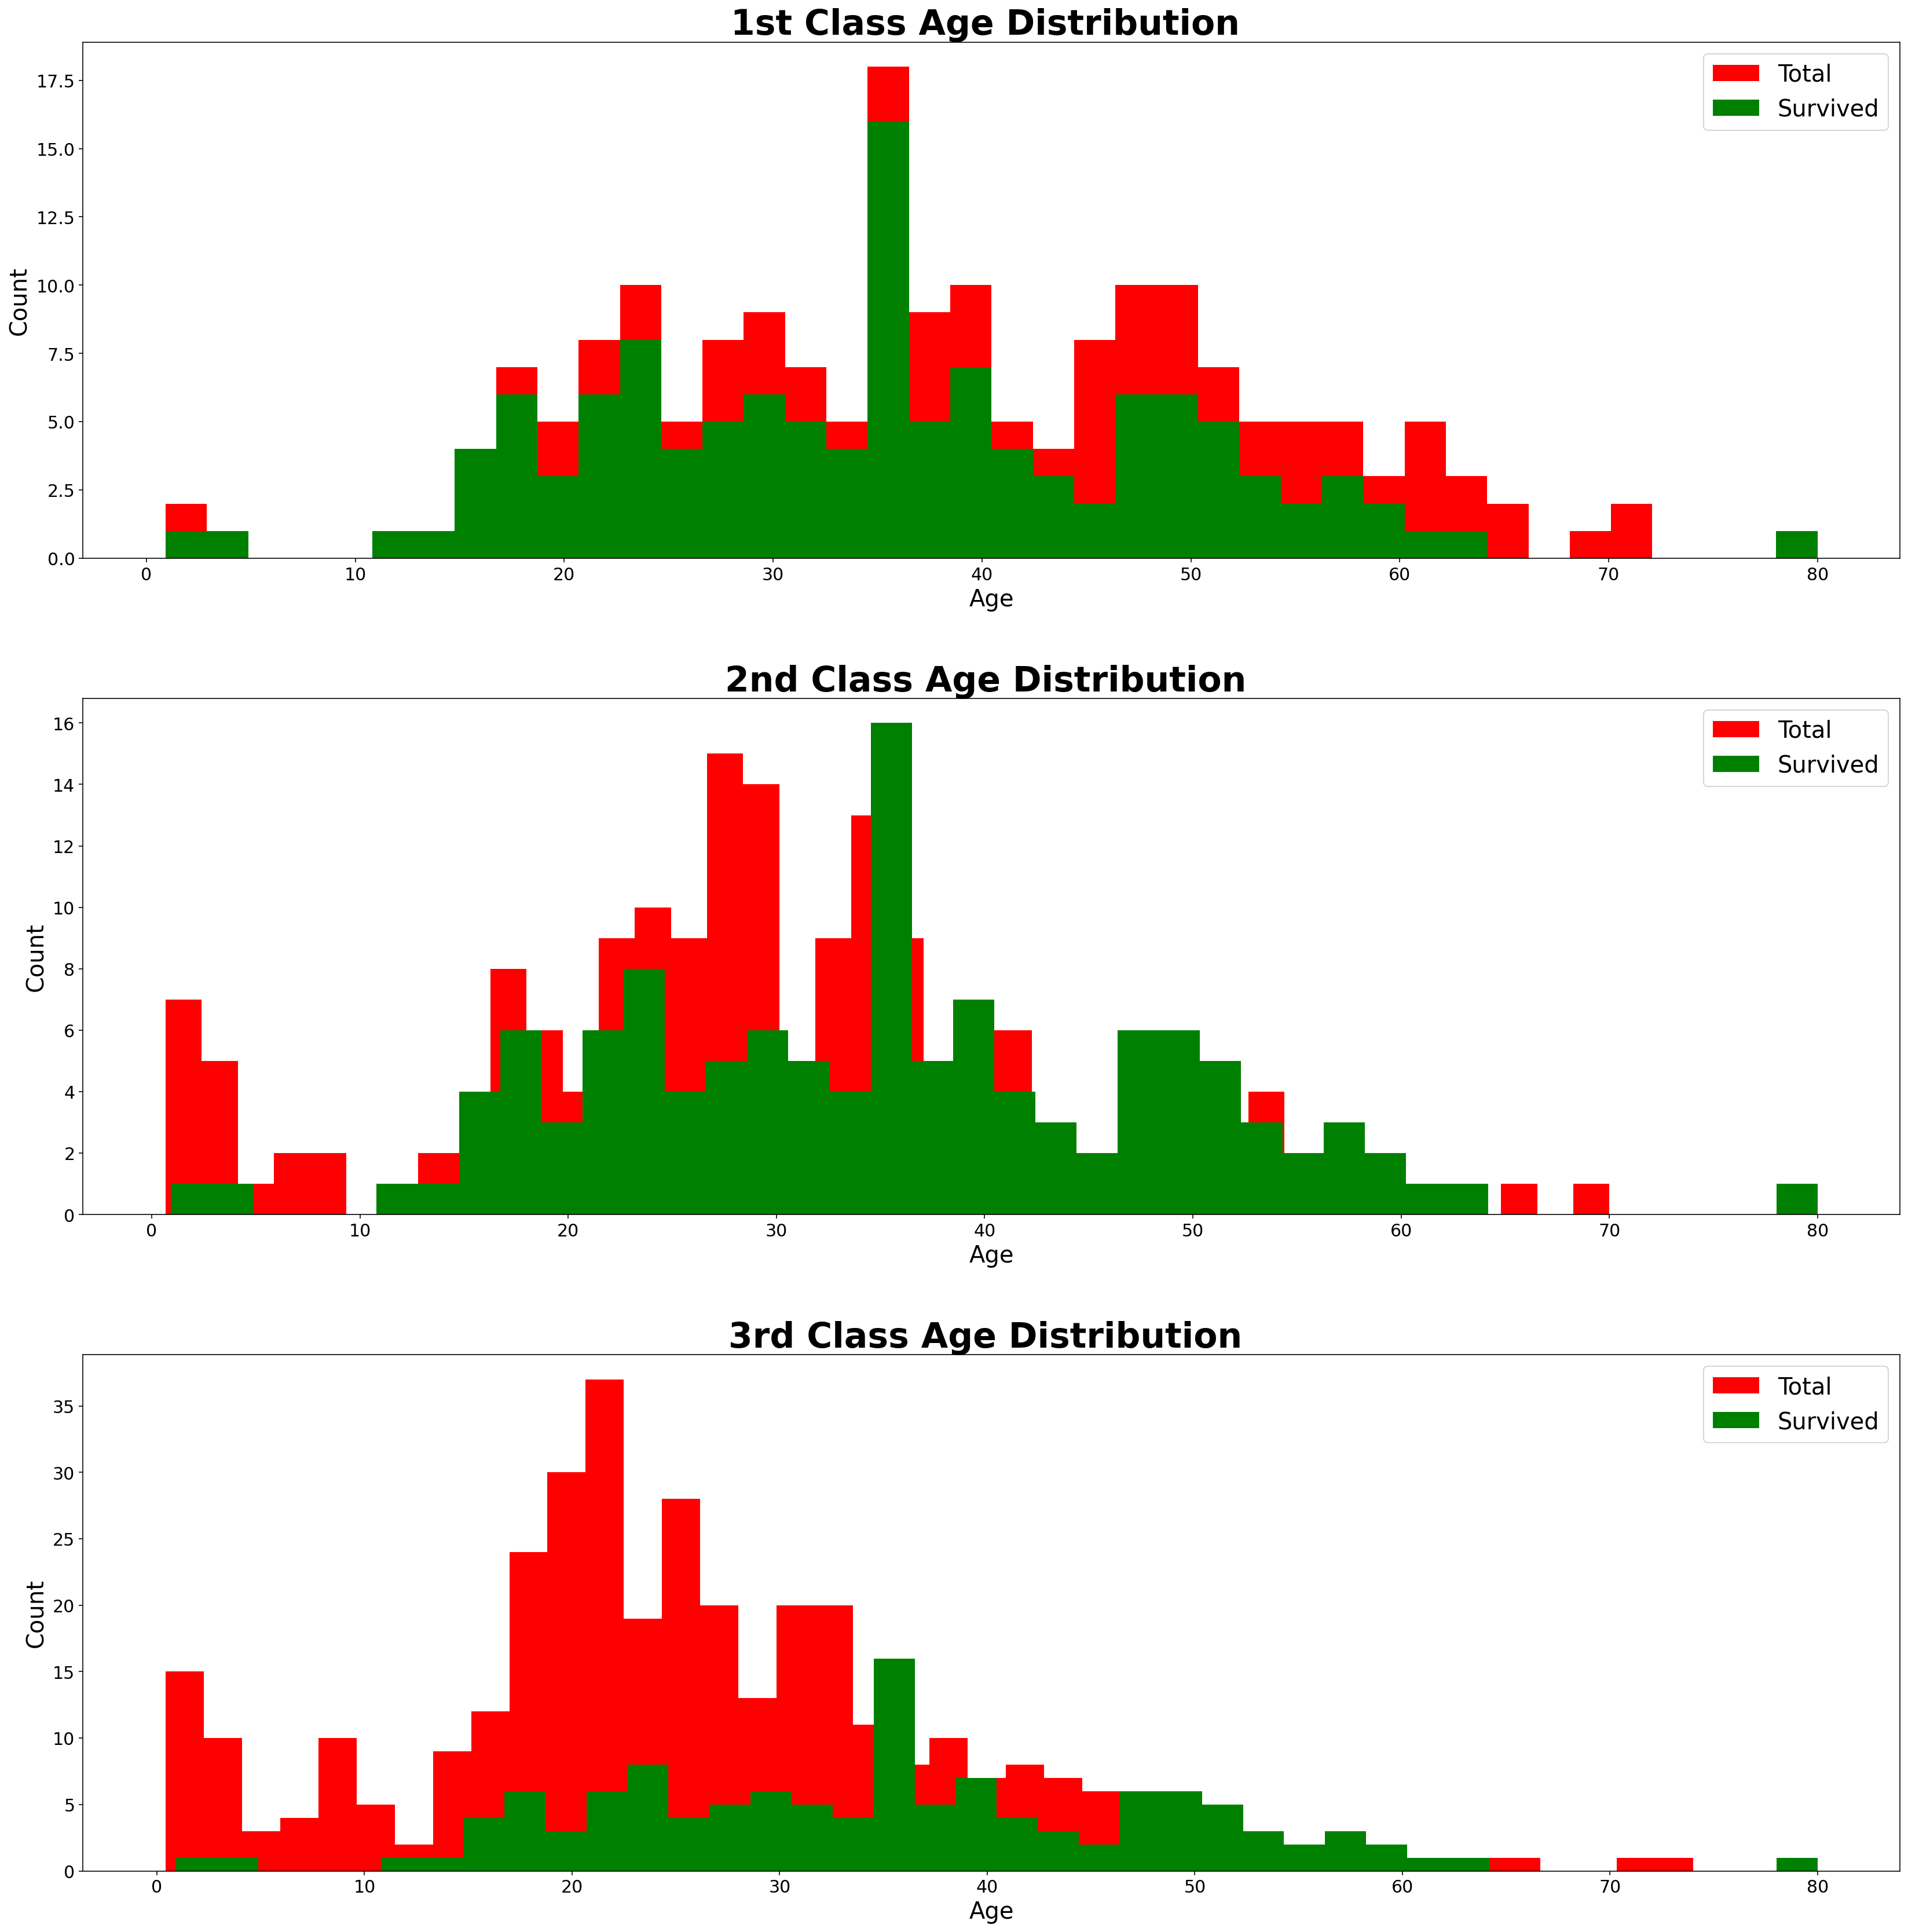

In [14]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(25,25))

fig.tight_layout(pad=10)
label = ['Total', 'Survived']
ax1.hist(x=train['Age'][train['Pclass']==1], bins=40, label=label, color='red')    
ax1.hist(x=train['Age'][train['Pclass']==1][train['Survived']==1], bins=40, label=label[1], color='green')

ax2.hist(x=train['Age'][train['Pclass']==2], bins=40, label=label[0], color='red')
ax2.hist(x=train['Age'][train['Pclass']==1][train['Survived']==1], bins=40, label=label[1], color='green')

ax3.hist(x=train['Age'][train['Pclass']==3], bins=40, label=label[0], color='red')
ax3.hist(x=train['Age'][train['Pclass']==1][train['Survived']==1], bins=40, label=label[1], color='green')

ax1.set_title('1st Class Age Distribution ',fontweight="bold", size=30) # Title
ax2.set_title('2nd Class Age Distribution ',fontweight="bold", size=30) # Title
ax3.set_title('3rd Class Age Distribution ',fontweight="bold", size=30) # Title;

for each in [ax1, ax2, ax3]:
    each.set_ylabel('Count', fontsize = 20) # Y label
    each.set_xlabel('Age', fontsize = 20) # X label
    each.tick_params(axis='both', which='major', labelsize=15)
    
    each.legend(prop={'size': 20});
                                               
                                               

In order to understand the survival data by class, it would be beneficial to study the layout of the different class cabins on the ship. 

Furthermore, superimposing this with information about the timeline of the incident might paint a clearer picture of the survival statistics.

<center><img src=https://www.encyclopedia-titanica.org/files/1/figure-one-side-view.gif></center>

<center>***Fig 1. Side View of the Titanic showing class distribution***</center>

From the above image, we see that the third class cabins were mostly at the bow of the ship where the initial impact occured. The first class on the other hand, was closest to the ship's deck, where the lifeboats would be accessed. 

This may have contributed to the higher higher mortality rate of the lower class passengers. 

The evacuation procedure however, was probably the deciding factor in the survival data. The women and children, as well as passengers in higher class cabins, were given priority when boarding the lifeboats. (see source: https://www.nationalarchives.gov.uk/museum/item.asp?item_id=43&sequence=1)

## 1.3 - SibSP and ParCh columns

These two columns for each passenger represent their: 
- Siblings and Parents
- Parents and children

We can examine how the count affects survival rate

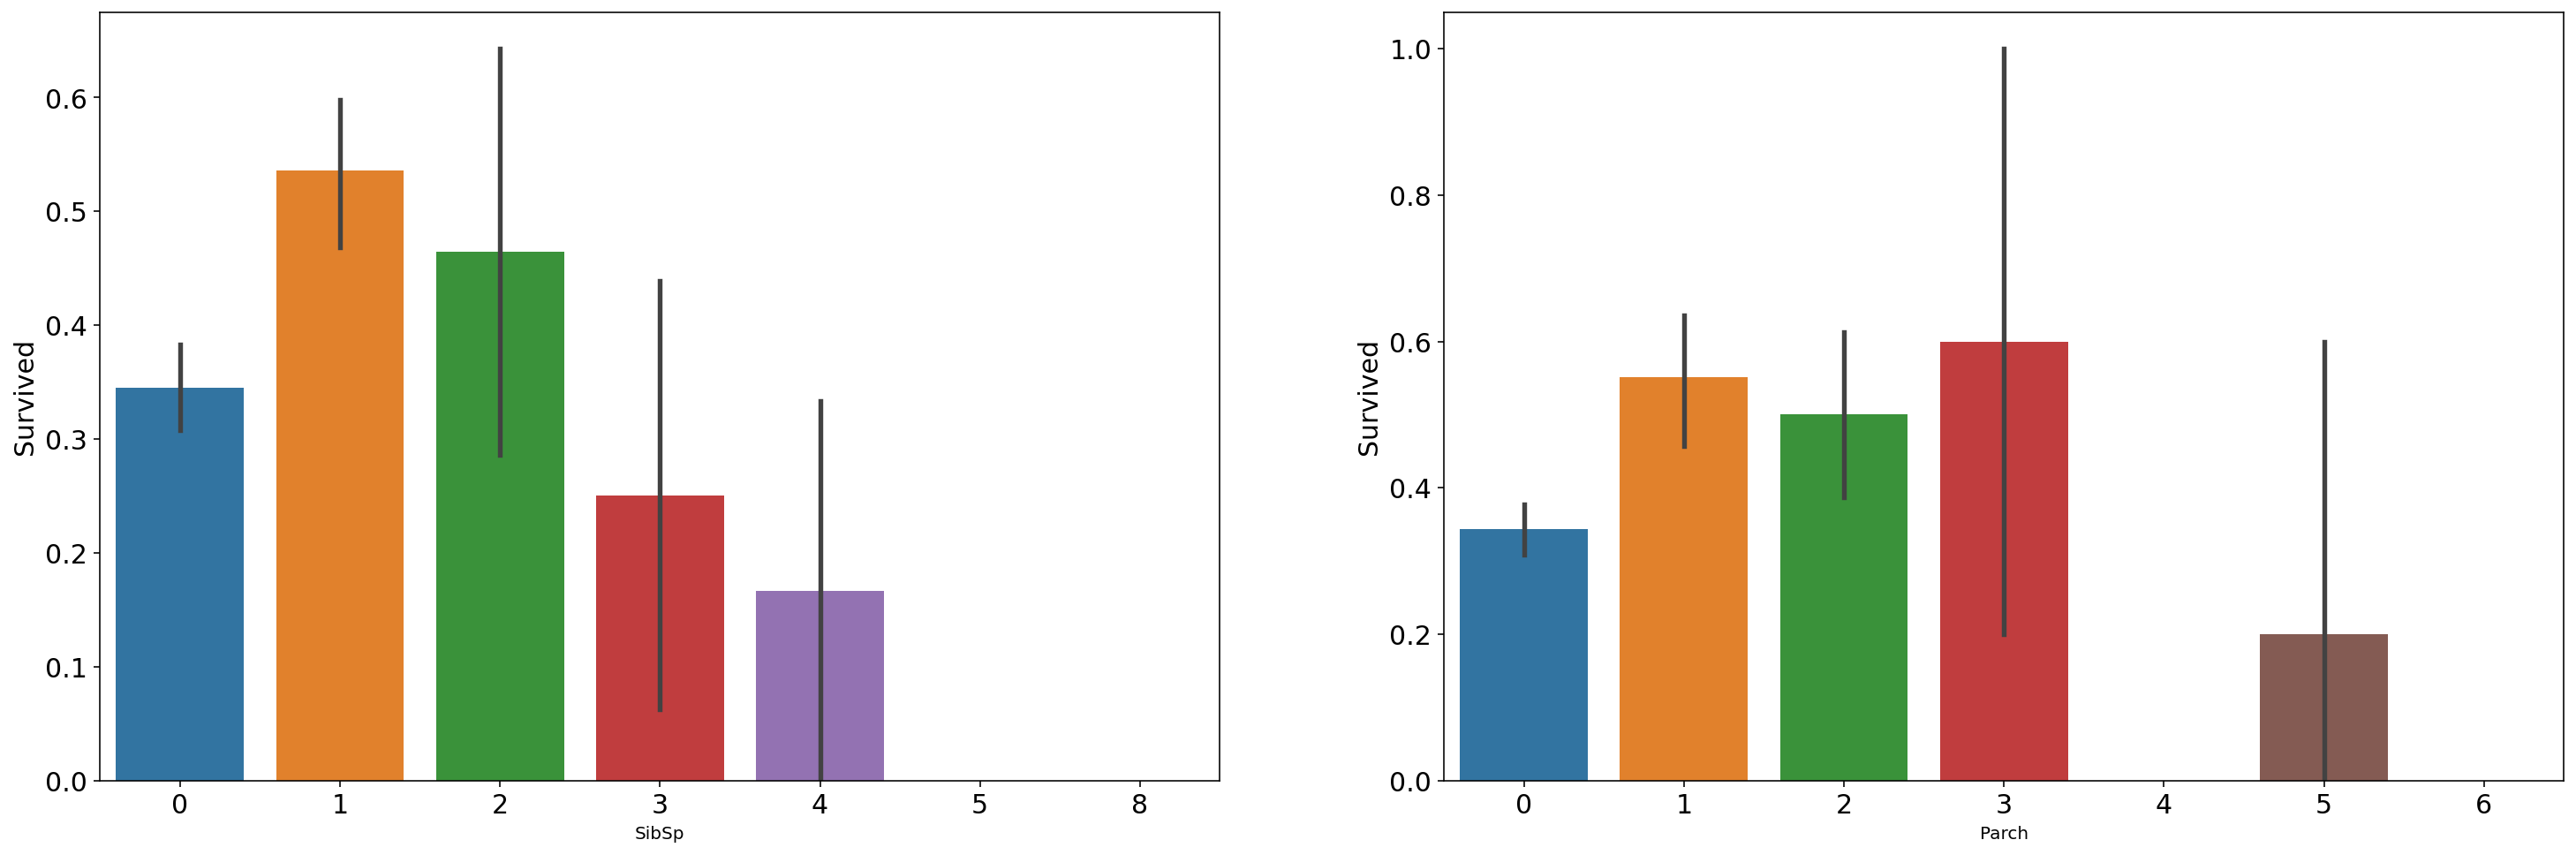

In [15]:
fig, ax = plt.subplots(1,2, figsize=(25,8))
#sns.barplot(x=train['SibSp'][train['Pclass']==1], y='Survived', data=train, ax=ax[0])
#sns.barplot(x=train['SibSp'][train['Pclass']==3], y='Survived', data=train, ax=ax[1])

sns.barplot(x='SibSp', y='Survived', data=train, ax=ax[0])
sns.barplot(x='Parch', y='Survived', data=train, ax=ax[1])

for each in [ax[0], ax[1]]:
    each.set_ylabel('Survived', fontsize = 15) # Y label
    #each.set_xlabel('Age', fontsize = 15) # X label
    each.tick_params(axis='both', which='major', labelsize=15)
    
fig.show()



- Seemingly, there is no significant trend in the `Parch` plot. 
- The `SibSp` plot however, shows decreasing likelihood of survival with increasing number of siblings/spouses.

# 2 - Feature Engineering

Before pre-processing, we combine the training and test data into one dataframe. In preparing the data, we want to maintain consistency between both sets.

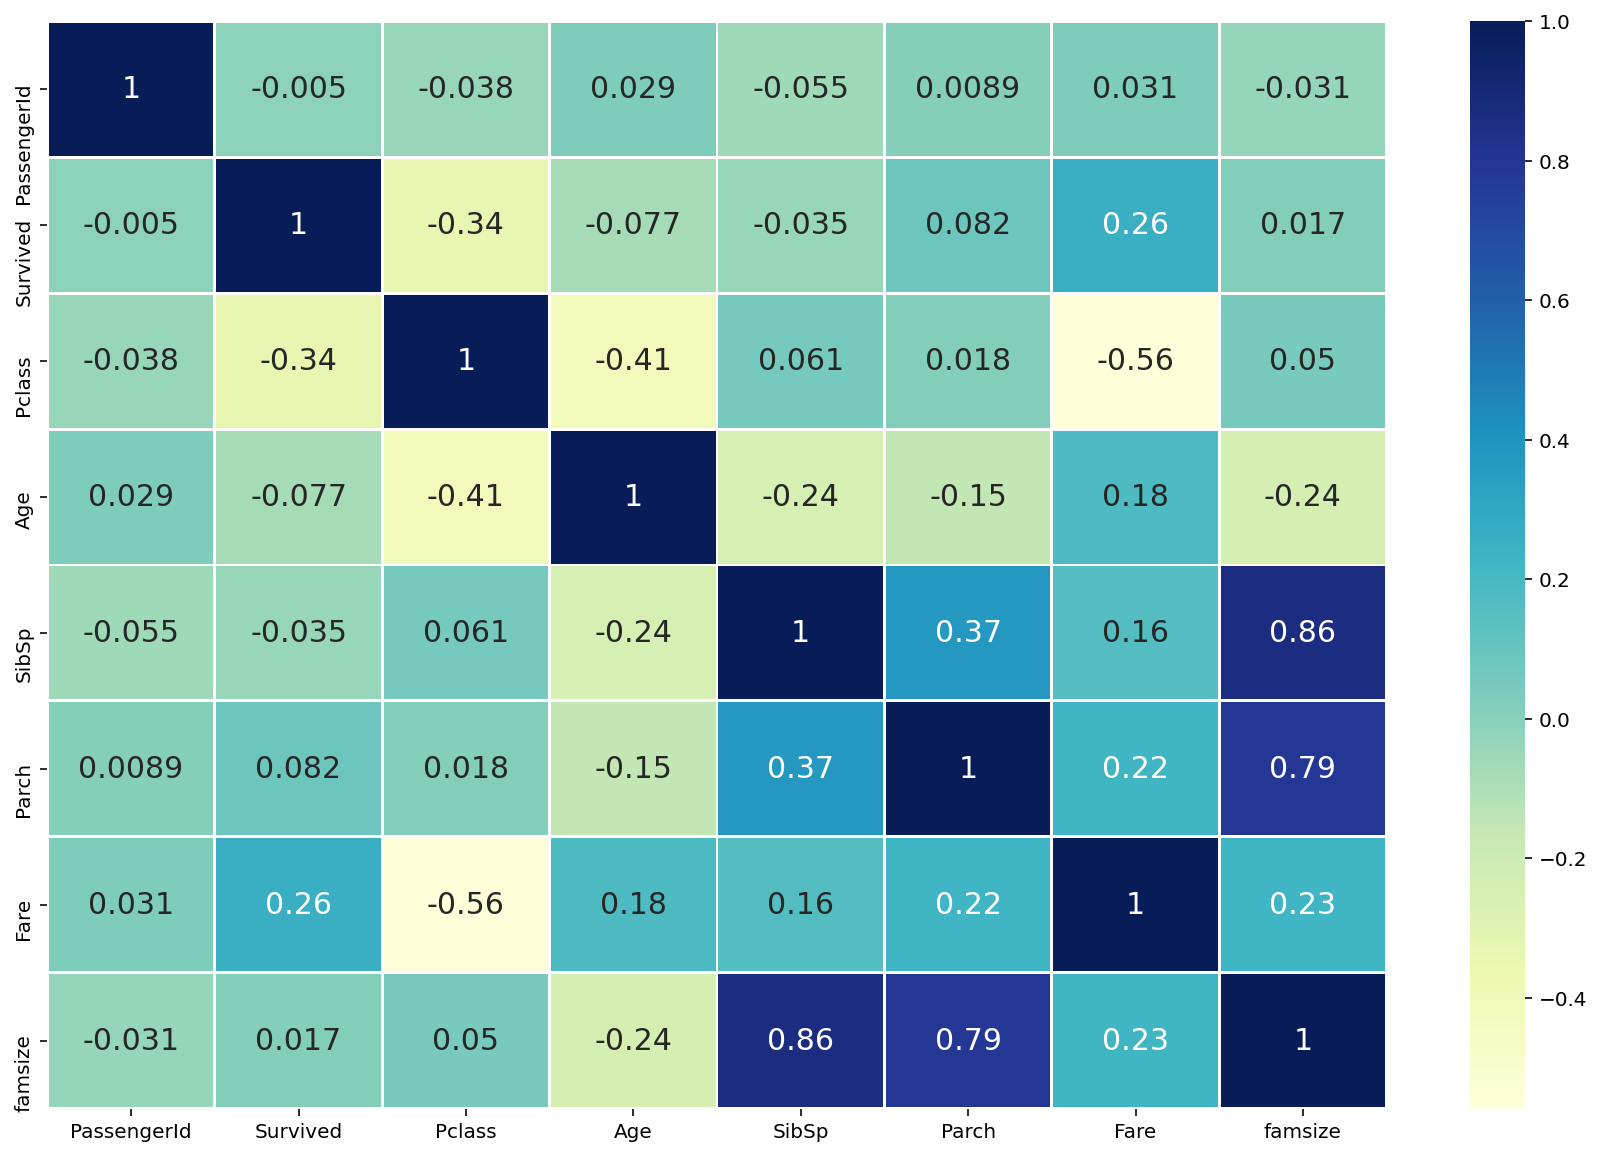

In [16]:
df = pd.concat([train, test], sort=False, ignore_index=True)
df2 = df.copy()
df2['famsize'] = df2['SibSp'] + df2['Parch'] + 1

# Checking correlations with Heatmap

fig, ax = plt.subplots(figsize=(15, 10))
ax =sns.heatmap(df2.corr(), 
                annot=True,
                cmap='YlGnBu',
                linewidths=1,  
                annot_kws={'size':15})

In [17]:
(df2.isnull().sum()/df.shape[0])*100

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
famsize         0.000000
dtype: float64

Only four features have missing values, and will each be transformed.
1. The `Age` feature is missing 20% of its data.As seen from the EDA carried out earlier, as well as the correlation chart above, this feature significantly influences the target variable and so will be imputed.

2. The `Fare` feature also affects the target since it is an indicator of what class a passenger was on. Since it has only 0.07% of its data missing, we will keep the feature.

3. The `Cabin` column has over 70% of its data missing, making it unreasonable to try and impute. We can proceed to drop this feature

4. `Embarked`, like fare, has very little data missing (about 0.15%). We can thus keep them for futher processing

### 2.1 - Name column
This column will need to be tranformed into a useful feature as a name by itself will hardly split our data in any meaningful way since they are all unique. 

The titles however could provide a means to further classify passengers. 

To do this, we will extract the titles and create a new column to hold this information

In [18]:
df2["Title"] = df2['Name'].str.extract(' ([A-Za-z]+)\.')
df2.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,famsize,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr


We can see what titles are used, and how frequently each occur in our dataset

In [19]:
df2['Title'].value_counts(normalize=True)*100

Mr          57.830405
Miss        19.862490
Mrs         15.049656
Master       4.660046
Rev          0.611154
Dr           0.611154
Col          0.305577
Major        0.152788
Mlle         0.152788
Ms           0.152788
Sir          0.076394
Mme          0.076394
Capt         0.076394
Don          0.076394
Lady         0.076394
Countess     0.076394
Jonkheer     0.076394
Dona         0.076394
Name: Title, dtype: float64

Outside the first four, the rest of the titles appear to be infrequent. We can group them together as `scarce`.

Lets visually inspect this subset of passengers with scarce titles.

In [20]:
df2[~df2['Title'].isin(['Mr','Mrs','Master','Miss'])]

# Uncomment the lines below for a more concise summary

#print(df2[~df2['Title'].isin(['Mr','Mrs','Master','Miss'])].Pclass.value_counts())
#print(df2[~df2['Title'].isin(['Mr','Mrs','Master','Miss'])].Sex.value_counts())
#print(df2[~df2['Title'].isin(['Mr','Mrs','Master','Miss'])].Embarked.value_counts())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,famsize,Title
30,31,0.0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,1,Don
149,150,0.0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,1,Rev
150,151,0.0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,1,Rev
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,3,Dr
249,250,0.0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,2,Rev
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,1,Dr
369,370,1.0,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,1,Mme
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,1,Dr
443,444,1.0,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S,1,Ms
449,450,1.0,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,1,Major


One immediate observation is that these are mostly 1st and 2nd class passengers with only one 3rd class passenger, which makes sense considering the scarce titles are typically associated with high-status individuals who are more likely to afford higher ticket prices.

In [21]:
df2['Title'] = df2['Title'].replace('Mme', 'Mrs')
df2['Title'] = df2['Title'].replace(['Mlle','Ms'], 'Miss')
df2['Title'] = df2['Title'].replace(['Capt','Don','Jonkheer','Sir',
                                    'Major','Rev','Col', 'Countess',
                                    'Dona','Lady', 'Dr'], 'Scarce')


#df2['Title'] = df['Title'].replace(['Countess','Dona','Lady'], 'femScarce')
#df2['Title'] = df['Title'].replace(['Capt','Don','Jonkheer','Sir','Major','Rev','Col'], 'maleScarce')

titledict = {"Master": 1,
             "Miss": 2,
             "Mr": 3,
             "Mrs": 4,
             "Scarce": 5}

# Non-Exhaustive mapping and retaining existing variables for non-matches
df2['Title'] = df2['Title'].map(titledict).fillna(df2['Title'])   

In [22]:
df2['Title'].value_counts()

3    757
2    264
4    198
1     61
5     29
Name: Title, dtype: int64

Having extracted the titles from the names, we can proceed to drop the name column

In [23]:
df2.drop(columns=['Name'], axis=1, inplace=True)

### 2.2 - Ticket Column

We also drop this column since it holds no useful information for our model

In [24]:
df2.drop(columns=['Ticket'], axis=1, inplace=True)

### 2.3 - Sex Column
Here we simply encode the `male` and `female` classes into **1** and **0** respectively

In [25]:
sexdict = {"male": 1, "female":0}
df2['Sex'] = df2['Sex'].map(sexdict)

# Check
df2['Sex'].value_counts()

1    843
0    466
Name: Sex, dtype: int64

### 2.4 - Embarked Column


In [26]:
df2['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [27]:
df[df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


A close look at the details of the two passengers missing embarkment data shows they shared the same  Cabin and hence Pclass. 

Infact, the Fare and ticket are also exactly the same, which suggests they most likely were travelling together. We can thus say with certainty they would have had the same embarkment point.

We go on to impute the missing data using to modal value, `S` of this column.

In [28]:
df2['Embarked'] = df2['Embarked'].fillna('S')

# Now Encode the categorical 'Embarked' column into numericals
embark_dict = {"S": 0, "C":1, "Q":2}
df2['Embarked'] = df2['Embarked'].map(embark_dict)

### 2.5 - Fare Column

Let's take a look at the entries missing fare data

In [29]:
df2[df2['Fare'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,famsize,Title
1043,1044,NaN,3,1,60.5,0,0,NaN,NaN,0,1,3


It is a single passenger in the third class, so we will use the modal value (since it is by far the most frequently occuring as seen below) for that subset of passengers 

0    8.05
dtype: float64


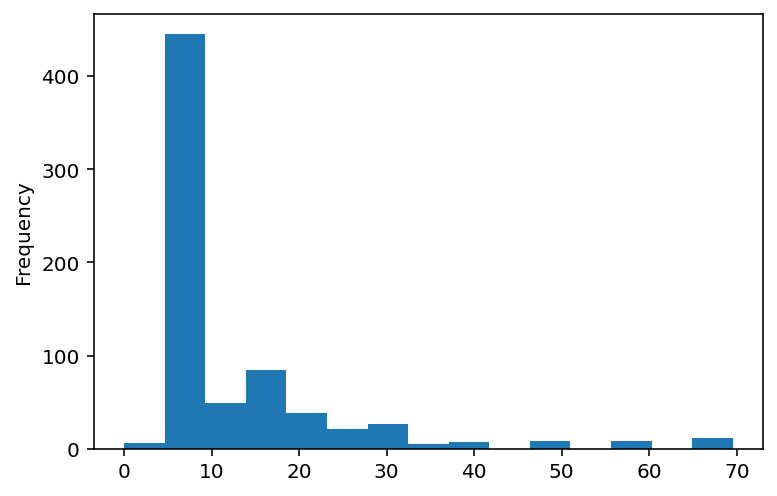

In [30]:
df2[df2['Pclass']==3].Fare.plot(kind='hist', bins=15);
print(df2[df2['Pclass']==3].Fare.mode())


In [31]:
df2['Fare'].fillna(8.05, inplace=True)

### 2.6 - Cabin Column

As seen earlier, this column has 77% of its values missing, so we decide to drop it.

In [32]:
df2.drop(columns=['Cabin'], axis=1, inplace=True)

### 2.7 - Age column

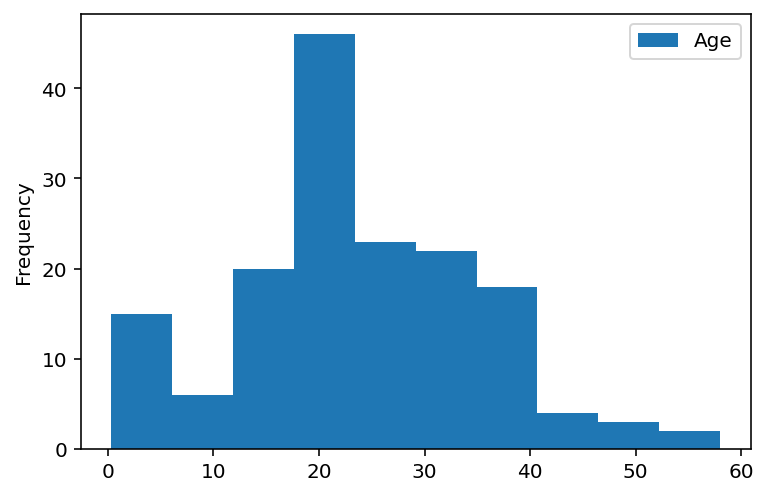

In [33]:
df3=df2.copy()
df3.head()

df3[(df3.Title.isin([1,2])) & (df3.SibSp==0)].plot(kind='hist', y='Age')

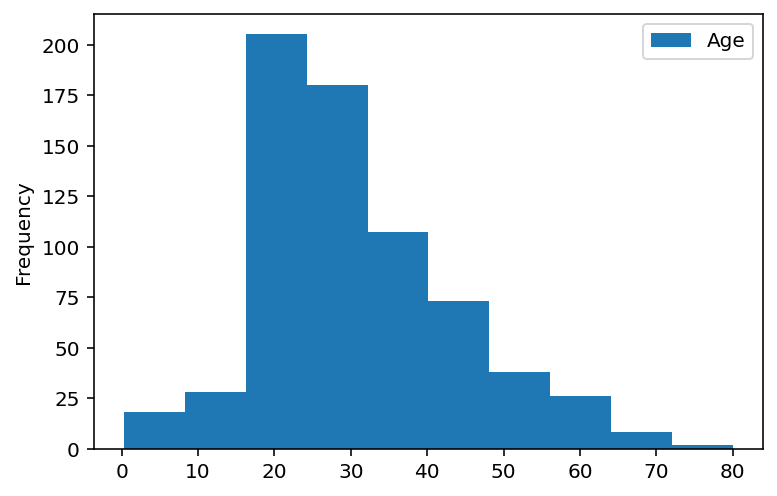

In [34]:
df3[(df3.SibSp==0)].plot(kind='hist', y='Age')

## 2.2 - Imputations

To impute the age, we use a linear regression model on selected column. The age is then predicted and imputed to a new column.

See more details on this method credited here: https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression

In [35]:
missing_columns = ["Age"]
df3 = df2.copy()

def random_imputation(df, feature):
    
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    df3[feature + '_imp'] = df3[feature]
    df3 = random_imputation(df3, feature)

In [37]:
from sklearn import linear_model

random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = df3[feature + '_imp']
    parameters = list(set(df3.columns) - set(missing_columns) - {feature + '_imp'} - set(["Survived","PassengerId","Sex","Embarked","Parch","SibSp"]))
    
    model = linear_model.LinearRegression()
    model.fit(X=df3[parameters], y=df3[feature + '_imp'])
    
    #Standard Error of our regression estimates equals the standard deviations of the errors of each estimate
    predict = model.predict(df3[parameters])
    std_error = (predict[df3[feature].notnull()] - df3.loc[df3[feature].notnull(), feature + '_imp']).std()
    
    #We retain the index of the missing data from the initial dataframe
    random_predict = np.random.normal(size = df3[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(df3[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df3[feature].isnull()) & 
                                                                            (random_predict > 0)]

In [39]:
df3.drop(columns=['Age'], axis=1, inplace=True)

In [40]:
df3.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,famsize,Title,Age_imp
0,1,0.0,3,1,1,0,7.2500,0,2,3,22.0
1,2,1.0,1,0,1,0,71.2833,1,2,4,38.0
2,3,1.0,3,0,0,0,7.9250,0,1,2,26.0
3,4,1.0,1,0,1,0,53.1000,0,2,4,35.0
4,5,0.0,3,1,0,0,8.0500,0,1,3,35.0


# 3 - Modelling

In [41]:
df3.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
famsize          0
Title            0
Age_imp          0
dtype: int64

Let us now split the dataset and drop the `Survived` column from the test data

In [42]:
train = df3[:len(train)]
test = df3[len(train):]

test.drop(columns=['Survived'], axis=1, inplace=True)

print(train.shape)
print(test.shape)

(891, 11)
(418, 10)


In [43]:
train.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Sex              int64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
famsize          int64
Title            int64
Age_imp        float64
dtype: object

Convert Survived column to integer:

In [44]:
train['Survived'] = train['Survived'].astype(int)

In [45]:
X = train.drop(columns=['Survived'], axis=1)
y = train['Survived']

Now we're going to try the following models
>* Logistic Regression
>* K-Nearest Neighbours classifiers
>* Random Forest Classifier
>* SVC
>* Decision Tree Classifier
>* Gradient Boosting Classifier

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


models = {"Logistic Regression": LogisticRegression(),
          "K-Nearest Neighbours classifiers": KNeighborsClassifier(),
          "Random Forest Classifier": RandomForestClassifier(),
          "SVC": SVC(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "Gradient Boosting Classifier": GradientBoostingClassifier()}


def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates the given models.
    models: a dict of the different Sklearn ML models
    X_train: training data (without labels)
    X_test: Test data (without labels)
    y_train: training labels
    y_test: test labels
    """
    
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        model.fit(X_train, y_train)                          # Fit model to data
        model_scores[name] = model.score(X_test, y_test)       # Evaluate model, append scores to model_scores
    return model_scores

In [47]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             y_train=y_train,
                             X_test=X_val,
                             y_test=y_val)

model_scores

{'Logistic Regression': 0.8268156424581006,
 'K-Nearest Neighbours classifiers': 0.6480446927374302,
 'Random Forest Classifier': 0.8659217877094972,
 'SVC': 0.664804469273743,
 'Decision Tree Classifier': 0.7653631284916201,
 'Gradient Boosting Classifier': 0.8435754189944135}

Of the six classification methods we've tested, ***Random Forest Classifier*** appears the best. We will also take the ***Gradient Boosting Classifier*** and ***Logistic Regression*** for further tuning

## 3.1 - Hyperparameter tuning using RandomizedSearchCV

In [48]:
# Hyperparameter grid for LogisticRegression()
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Hyperparameter grid for RandomForestClassifier()
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Hyperparameter grid for GradientBoostingClassifier()
gb_grid = {"learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.1],
           "n_estimators": [1, 2, 4, 16, 32, 64],
           "max_depth": np.linspace(1, 10, 10, endpoint=True),
           "min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
           "min_samples_leaf": np.linspace(0.1, 0.5, 5, endpoint=True)}         

In [49]:
# Tune Logistic Regression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Tune Random Forest
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Tune Gradient Boosting
rs_gb = RandomizedSearchCV(GradientBoostingClassifier(),
                           param_distributions=gb_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)


# Fit hyperparameter search models
rs_log_reg.fit(X_train, y_train)

rs_rf.fit(X_train, y_train)

rs_gb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

### Logistic Regression score and best parameters

In [50]:
print(rs_log_reg.score(X_val, y_val))
print(rs_log_reg.best_params_)

0.8324022346368715
{'solver': 'liblinear', 'C': 0.23357214690901212}


### Random Forest score and best parameters

In [51]:
print(rs_rf.score(X_val, y_val))
print(rs_rf.best_params_)

0.8547486033519553
{'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_depth': None}


### Gradient Boost score and best parameters

In [52]:
print(rs_gb.score(X_val, y_val))
print(rs_gb.best_params_)

0.8044692737430168
{'n_estimators': 4, 'min_samples_split': 0.8, 'min_samples_leaf': 0.2, 'max_depth': 4.0, 'learning_rate': 0.25}


From the above, Random Forest still performs best. We can have another go at the random search with more tuned hyperparameters

## 2nd RandomSearchCV HyperParameter tuning

In [53]:
# Different hyperparameters for our RandomForestRegression model
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Setup hyperparameter search for RandomForestRegression
gs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

gs_rf.fit(X_train, y_train);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


In [54]:
gs_rf.best_params_

{'n_estimators': 660,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': None}

In [55]:
gs_rf.score(X_val, y_val)

0.8770949720670391

A score of 0.87 is pretty adequate. We can go on and build a model with the tuned parameters, and proceed to futher evaluation.

In [63]:
potential_model = RandomForestClassifier(n_estimators=660,
                                         min_samples_split=2,
                                         min_samples_leaf=3,
                                         max_depth=None)

potential_model.fit(X_train, y_train)

preds = potential_model.predict(X_val)

accuracy_score(preds, y_val)

0.8603351955307262

## 3.2 - Model Evaluation

###  ROC curve

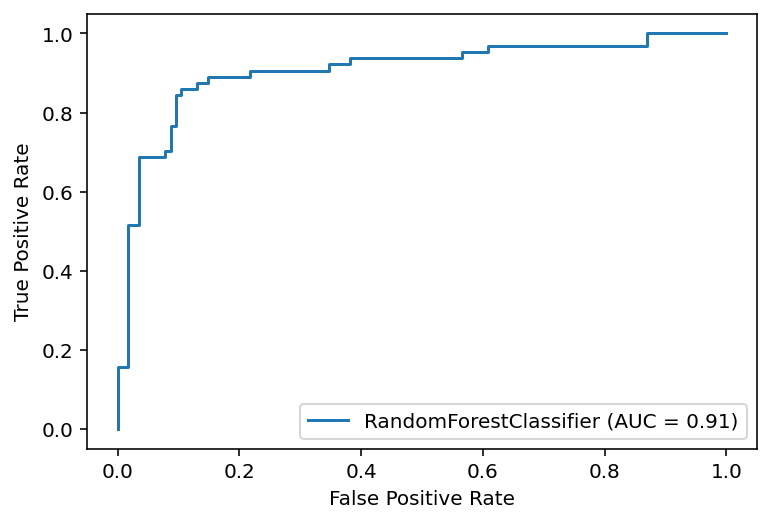

In [65]:
plot_roc_curve(potential_model, X_val, y_val);

###  Confusion Matrix

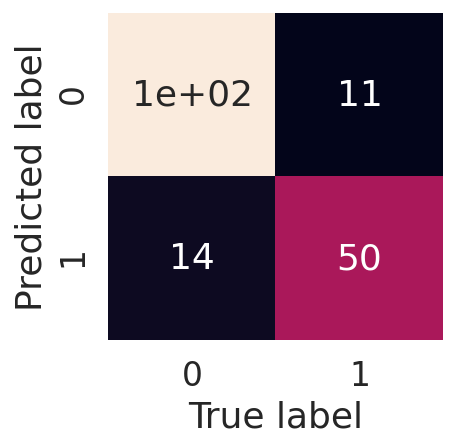

In [67]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    
    """
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
plot_conf_mat(y_val, preds)

### Classification Report

In [68]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       115
           1       0.82      0.78      0.80        64

    accuracy                           0.86       179
   macro avg       0.85      0.84      0.85       179
weighted avg       0.86      0.86      0.86       179



# 4 - Feature Importance 

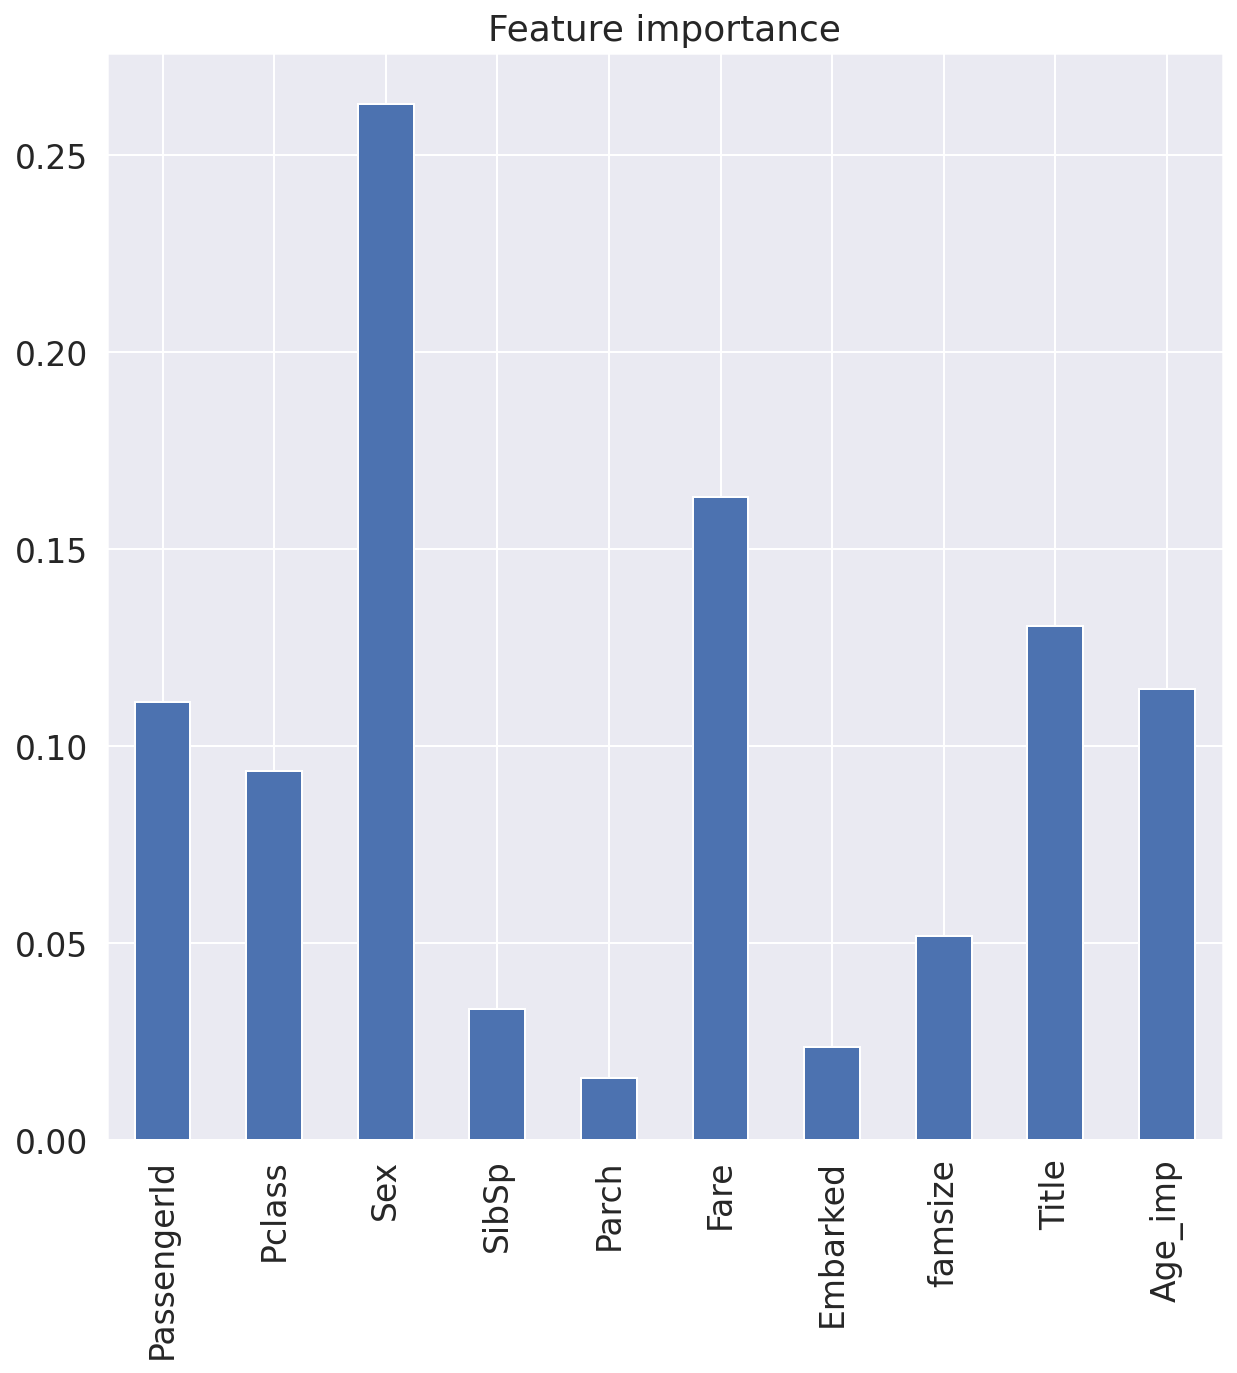

In [80]:
importance = potential_model.feature_importances_

feature_dict = dict(zip(test.columns, list(importance)))


feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature importance", legend=False, figsize=(10,10))

In [ ]:
##

In [90]:
fin_model = RandomForestClassifier(n_estimators=660,
                                   min_samples_split=2,
                                   min_samples_leaf=3,
                                   max_depth=None)

fin_model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=660,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Final Prediction and Test Submission

In [92]:
fin_preds = fin_model.predict(test)

solution = pd.DataFrame({"PassengerId": test["PassengerId"],
                           "Survived": fin_preds})                                               

In [97]:
solution.to_csv('submission.csv', index=False)

In [99]:
solution.shape

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
